In [44]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import json
import os

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False


In [45]:
pretrained_model = tf.keras.models.load_model("model.h5")

labels_file = open("labels.json", "r")
labels = json.loads(labels_file.read())

pretrained_model.trainable = False

# ImageNet labels
#decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions


In [46]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (128, 128))
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
#def get_imagenet_label(probs):
#  return decode_predictions(probs, top=1)[0][0]


In [47]:
def predict_image(image):
    predictions = pretrained_model.predict(image)
    prediction = predictions.argmax(axis=-1)
    map_labels = np.vectorize(lambda i: labels[str(i)])
    return str(map_labels(prediction)[0])

In [48]:
# Original Image

## INPUT 1 of 2 - THE IMAGE
image_raw = tf.io.read_file('persons-cropped-test/Adriana Lima/205.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)


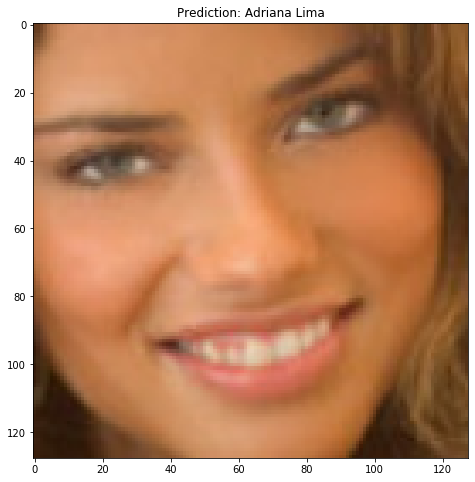

In [49]:
plt.figure()
plt.imshow(image[0])
#_, image_class, class_confidence = get_imagenet_label(image_probs)
#plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.title('Prediction: ' + predict_image(image))
plt.show()


In [50]:
# Create adversarial image

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


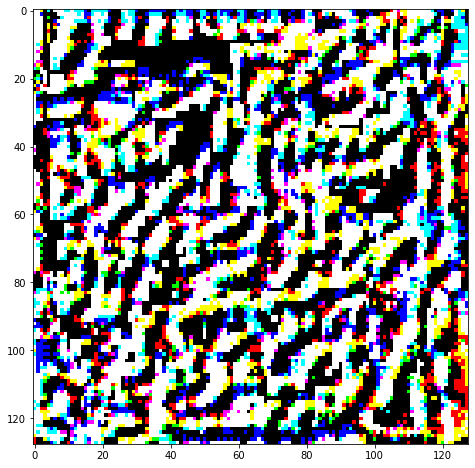

In [51]:
# Get the input label of the image.
## INPUT 2/2 - THE INDEX
label_index = 2
label = tf.one_hot(label_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0])


In [52]:
def display_images(image, description):
    #_, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    
    plt.figure()
    plt.imshow(image[0])
    plt.title(description + ", Prediction: " + predict_image(image))
    plt.show()


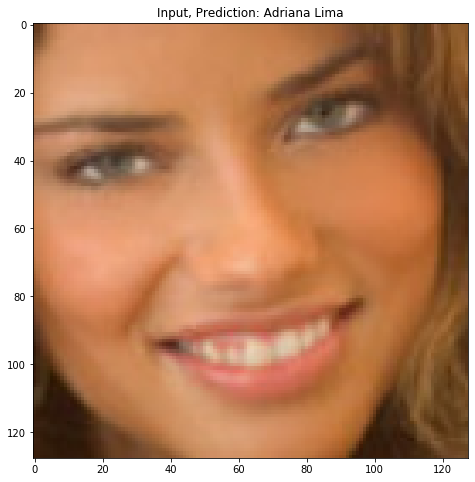

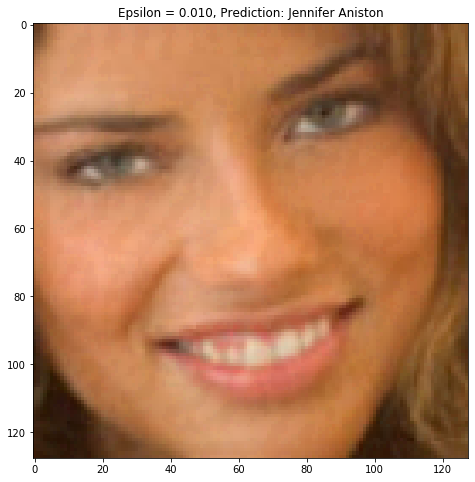

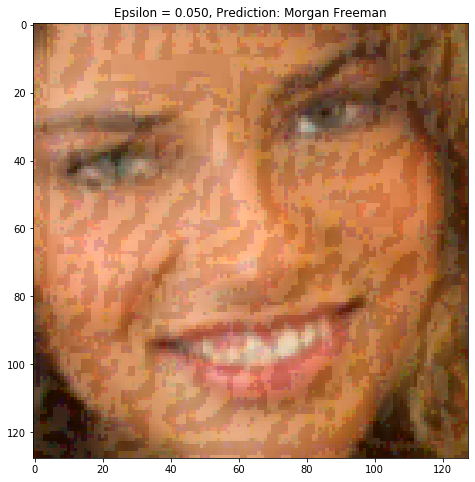

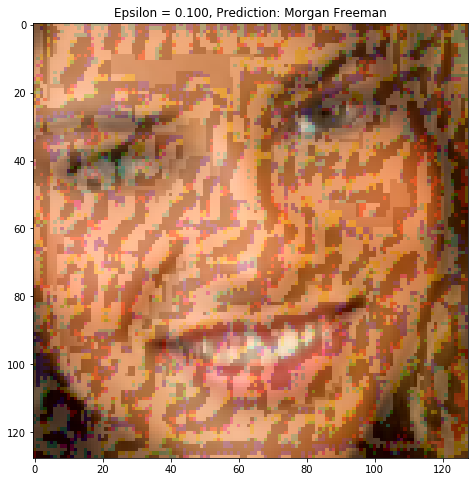

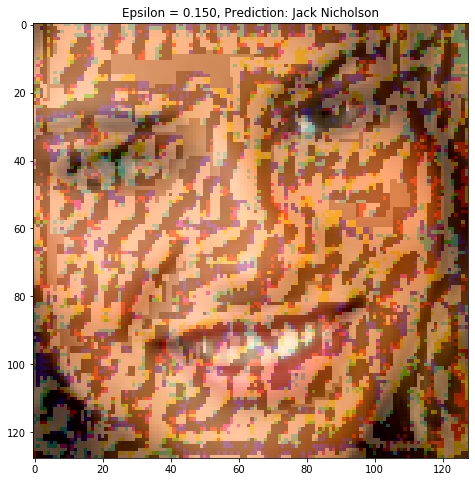

In [53]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i])
